In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import MuellerPotential
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
xgrid = np.linspace(-1.5, 1.0, 100)
ygrid = np.linspace(-0.5, 2, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

In [7]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [8]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [9]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [10]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0])
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min())

In [11]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [12]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [13]:
def getx(x):
    return x[:, 0]
def gety(x):
    return x[:, 1]

Plotting functions
-----

In [14]:
def low_energy_fraction(energies, Emax):
    low_energy_count = [np.count_nonzero(E<Emax) for E in energies]
    sizes = [E.size for E in energies]
    low_energy_fraction = np.array(low_energy_count) / sizes
    return low_energy_fraction

In [15]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [16]:
def energy_cut_z(ndim, nstd=3):
    z = np.random.randn(10000, ndim)
    zener = 0.5 * np.sum(z**2, axis=1)
    #return zener
    std = np.sqrt(np.mean((zener - zener.mean())**2))
    return zener.mean() + nstd*std

Mueller potential
---

In [17]:
paper_dir = '/Users/noe/data/open_projects/boltzmann_generators/coarsegraining_KL/'

In [18]:
params = MuellerPotential.params_default.copy()
params['k'] = 0.04
params['dim'] = 2
mueller = MuellerPotential(params=params)
#plt.figure(figsize=(5,5))
#double_well.plot_dimer_energy();
#plt.savefig(paper_dir + 'figs/doublewell_potential.pdf', bbox_inches='tight')

In [19]:
def plot_potential(labels=True, cbar=True, figsize=(7, 4), orientation='vertical', vmin=-10, vmax=-3):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=vmin, vmax=vmax)#, vmin=-10, vmax=-3)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.9, 6.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xticks([-1, 0, 1])
        plt.yticks([0, 1, 2])
    else:
        plt.xticks([])
        plt.yticks([])
    return cbar
    #plt.savefig(paper_dir + 'figs/doublewell_potential2D.pdf', bbox_inches='tight')    #plt.savefig(paper_dir + 'figs/doublewell_potential2D.pdf', bbox_inches='tight')

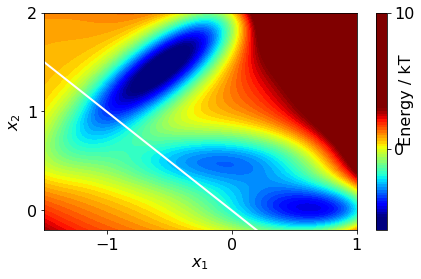

In [28]:
plot_potential(labels=True, cbar=True, vmin=-5, vmax=3)
plt.plot([-2, 2], [2, -2], color='white', linewidth=2)
plt.xlim(-1.5, 1)
plt.ylim(-0.2, 2)
plt.savefig(paper_dir + 'figs/mueller_true2d.pdf', bbox_inches='tight')

In [29]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [54]:
nsteps = 1000000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

In [55]:
#x_intermediate = np.array([[-0.05, 0.45]]) + np.array([[0.15, 0.05]]) * np.random.randn(100, 2)

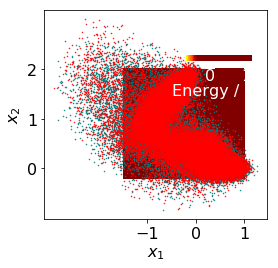

In [56]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.', markersize=1)
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.', markersize=1)
#plt.plot(x_intermediate[:, 0], x_intermediate[:, 1], color='orange', linewidth=0, marker='.', markersize=1)
#plt.savefig(paper_dir + 'figs/mueller/potential_horizontal.pdf', bbox_inches='tight', transparent=True)

In [57]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

Coarse-graining
-------

In [58]:
# Free energy:
proj_dir = np.array([[0.7],[-0.7]])

In [59]:
x_CG = x.dot(proj_dir)[:, 0]
xval_CG = xval.dot(proj_dir)[:, 0]
x_CG_aug = np.vstack([x_CG, np.random.randn(x_CG.size)]).T
xval_CG_aug = np.vstack([xval_CG, np.random.randn(xval_CG.size)]).T

In [60]:
epochsZ = 2500
batchsize_ML = 128
temperature = 1.0
explore = 1.0

In [61]:
bg = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=4, nl_hidden=[100, 10, 100], 
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [70]:
hist = bg.train_ML(x_CG_aug, xval=xval_CG_aug, lr=0.00025, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                   verbose=0, return_test_energies=True)

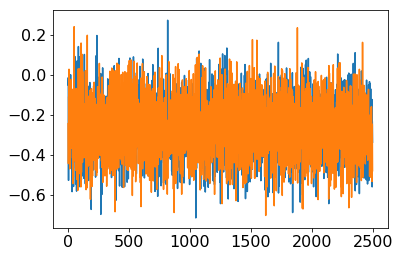

In [71]:
plt.plot(hist[0])
plt.plot(hist[1])

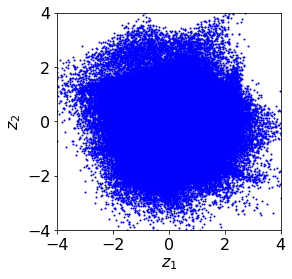

In [72]:
# Plot z distribution
ztraj = bg.transform_xz(x_CG_aug)
#z_int = bg.transform_xz(x_intermediate)
plt.figure(figsize=(4, 4))
plt.plot(ztraj[:, 0], ztraj[:, 1], linewidth=0, marker='.', markersize=2, color='blue')
#plt.plot(z_int[:, 0], z_int[:, 1], linewidth=0, marker='.', markersize=6, color='orange')
#plt.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=6, color='red')
circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
plt.gca().add_artist(circle)
plt.xlabel('$z_1$')
plt.xlim(-4, 4)
plt.ylabel('$z_2$')
plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
#plt.savefig(paper_dir + 'figs/mueller/zdist.pdf', bbox_inches='tight', transparent=True)

In [73]:
_, sample_x, _, sample_e, sample_logw = bg.sample(temperature=1.0, nsample=100000)

In [74]:
# Free energy:
proj = sample_x[:, 0]

No handles with labels found to put in legend.


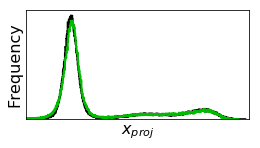

In [75]:
plt.figure(figsize=(4,2))
nsample = 100000
plt.hist(x_CG, 1000, histtype='step', color='black', linewidth=2, density=True);
plt.hist(proj, 1000, histtype='step', color='#00BB00', linewidth=2, density=True);
plt.xlim(-2, 1)
plt.yticks([]);
plt.xlabel('$x_{proj}$')
plt.ylabel('Frequency')
plt.xticks([]);
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
#plt.savefig(paper_dir + 'figs/mueller/hist_samplex.pdf', bbox_inches='tight', transparent=True)

In [76]:
# Reference calculation:
xwild = np.array([-1.5, -0.2]) + np.array([2.5, 2.2]) * np.random.rand(1000000, 2)
xwild_ener = mueller.energy(xwild)
xwild_w = np.exp(-(xwild_ener-xwild_ener.min()))
xwild_proj = xwild.dot(proj_dir)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


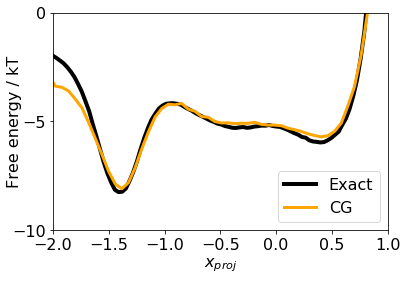

In [83]:
plt.figure(figsize=(6, 4))
hist, bin_edges = np.histogram(proj, bins=100)
bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_values_ref, -np.log(hist_ref), linewidth=4, color='black', label='Exact')
plt.plot(bin_values, -np.log(hist)+1.7, color='orange', linewidth=3, label='CG')
plt.xlim(-2, 1)
plt.ylim(-10, 0)
plt.yticks([-10, -5, 0])
plt.xlabel('$x_{proj}$')
plt.ylabel('Free energy / kT', labelpad=-10)
plt.legend()
plt.savefig(paper_dir + 'figs/mueller_1d.pdf', bbox_inches='tight', transparent=True)